# Use OSMnx to calculate street network indicators

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd

%matplotlib inline
ox.config(use_cache=True, log_console=False)
ox.__version__

'1.1.2'

## Calculate basic street network measures (topological and geometric)

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place("Piedmont, California, USA"))
stats["circuity_avg"]

/Users/junhyun/.pyenv/versions/3.8.5/envs/openstreetmap/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


1.090563209410014

To calculate density-based stats, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [3]:
# get the street network for a place, and its area in square meters
place = "Piedmont, California, USA"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type="drive")

/Users/junhyun/.pyenv/versions/3.8.5/envs/openstreetmap/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/Users/junhyun/.pyenv/versions/3.8.5/envs/openstreetmap/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [4]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             346
m                                                                             935
k_avg                                                                    5.404624
edge_length_total                                                      113098.828
edge_length_avg                                                        120.961313
streets_per_node_avg                                                     2.959538
streets_per_node_counts            {0: 0, 1: 34, 2: 0, 3: 262, 4: 47, 5: 2, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.09826589595375723, 2: 0.0, 3: 0....
intersection_count                                                            312
street_length_total                                                     58483.805
street_segment_count                                                          489
street_length_avg                                                      119.598783
circuity_avg    

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [5]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,346.000
m,935.000
k_avg,5.405
edge_length_total,113098.828
edge_length_avg,120.961
streets_per_node_avg,2.960
intersection_count,312.000
street_length_total,58483.805
street_segment_count,489.000
street_length_avg,119.599


### Inspect betweenness centrality

In [6]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.3109959555106168)

In the city of Piedmont, California, the node with the highest betweenness centrality has ~31% of all shortest paths running through it. Let's highlight it in the plot:

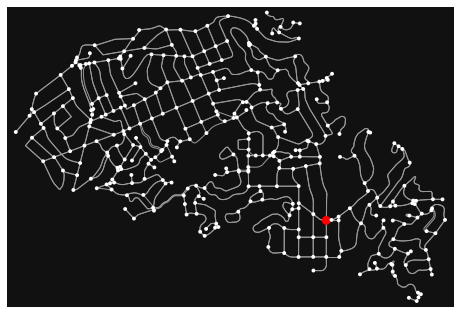

In [7]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

~30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

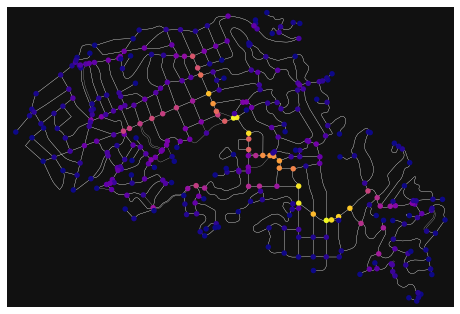

In [8]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.